c:\users\debora\anaconda3\envs\ai_env\lib\site-packages\ipykernel_launcher.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  if sys.path[0] == '':


Using Tensorflow: 2.6.0
Found 13957 files belonging to 2 classes.
Using 11166 files for training.
Found 13957 files belonging to 2 classes.
Using 2791 files for validation.
Found 13957 files belonging to 2 classes.
Using 2791 files for validation.
x_train.shape:  (10, 64, 64, 3)
y_train.shape:  (10, 2)
x_test.shape:  (10, 64, 64, 3)
y_test.shape:  (10, 2)
x_test.shape:  (10, 64, 64, 3)
y_test.shape:  (10, 2)
Clasele distincte sunt:  ['normal', 'covid']
0.0 0.9844095
Numarul de clase unice: 2
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 60, 60, 16)        1216      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 26, 26, 32)        12832     
__________________

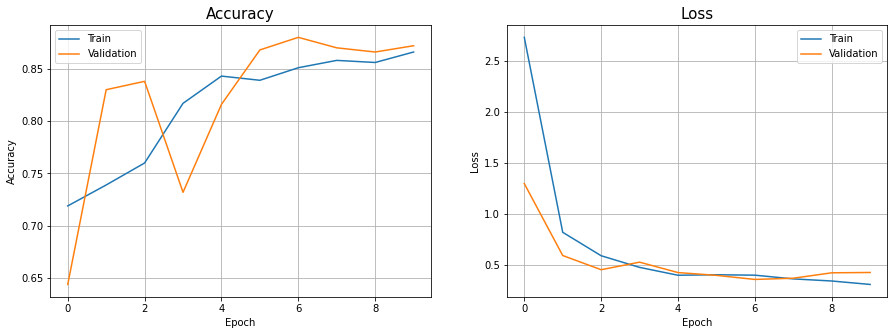

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'covid_dataset/test'

In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
import pathlib as pt
import yaml
from tensorflow.keras.preprocessing.image import ImageDataGenerator

config = None
with open('config.yml') as f: # reads .yml/.yaml files
    config = yaml.load(f)

print(f"Using Tensorflow: {tf.__version__}")

# DATA_PATH = pt.Path(r"C:\Users\Debora\Desktop\AI\AI-intro\5_Retele_Neurale\covid_dataset")
DATA_PATH = pt.Path(r"C:\Users\Debora\Desktop\AI\Teme_suplimentare\retele_convolutionale\covid_dataset")
VAL_SPLIT = 0.2
BATCH_SIZE = config['bs']
img_size = config['size']
nr_epochs = config['n_epochs']
ds_dir = 'covid_dataset'

# Date de training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=123,
  image_size=img_size,
  class_names=['normal', 'covid'],
  label_mode='categorical', 
  batch_size=BATCH_SIZE)

# Date de testing 
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  validation_split=VAL_SPLIT,
  subset="validation",
  seed=123,
  shuffle=False,
  image_size=img_size,
  class_names=['normal', 'covid'],
  label_mode='categorical',
  batch_size=BATCH_SIZE)

# Date de validare
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=123,
  image_size=img_size,
  class_names=['normal', 'covid'],
  label_mode='categorical', 
  batch_size=BATCH_SIZE)

x_train, y_train = next(iter(train_ds))
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)

x_test, y_test = next(iter(test_ds))
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_valid, y_valid = next(iter(valid_ds))
print('x_test.shape: ', x_valid.shape)
print('y_test.shape: ', y_valid.shape)


# Numele clasero distincte
class_names = train_ds.class_names
print('Clasele distincte sunt: ', class_names)

# Normaliarea setului de date
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_valid_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]

# Imaginile vor avea valori in intervalul `[0,1]`.
print(np.min(first_image), np.max(first_image))

# Dimensionarea imaginilor
image_dim = x_train[0].shape

# Numarul de clase unice
nr_clase = len(np.unique(y_train))
print(f'Numarul de clase unice: {nr_clase}')

# API secvential
n1 = config['n1']
n2 = config['n2']
n3 = config['n3']

# Definim arhitectura retelei convolutionale
model = Sequential()
model.add(Conv2D(n1, config['conv1'], activation='relu', padding='valid', input_shape=image_dim))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(n2, config['conv2'], activation='relu', padding='valid'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(n3, activation='relu'))
model.add(Dense(nr_clase, activation='softmax'))
model.summary()

# Definirea optimizatorului 
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

# Antrenarea modelului
history = model.fit(train_ds, steps_per_epoch = 100, validation_data = valid_ds, validation_steps = 50, epochs= nr_epochs)
model.save('covid.h5')

# Vizualizarea curbeor de invatare
def plot_acc_loss(result):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title('Accuracy', size=15)
    plt.legend()
    plt.grid(True)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.subplot(122)
    plt.plot(loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title('Loss', size=15)
    plt.legend()
    plt.grid(True)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.show()
    
plot_acc_loss(history)

# Evaluarea reala a performantelor
validation_datagen = ImageDataGenerator(rescale=1./255) 
test_generator = validation_datagen.flow_from_directory(ds_dir + '/test', target_size=(150, 150), batch_size=BATCH_SIZE, class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)